In [40]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
import torch

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV


In [5]:
# Load the data
df = pd.read_csv('dummy_data.csv') # src: https://www.kaggle.com/datasets/imyjoshua/average-time-spent-by-a-user-on-social-media
df.head()

,age,gender,time_spent,platform,interests,location,demographics,profession,income,indebt,isHomeOwner,Owns_Car
0,56,male,3,Instagram,Sports,United Kingdom,Urban,Software Engineer,19774,True,False,False
1,46,female,2,Facebook,Travel,United Kingdom,Urban,Student,10564,True,True,True
2,32,male,8,Instagram,Sports,Australia,Sub_Urban,Marketer Manager,13258,False,False,False
3,60,non-binary,5,Instagram,Travel,United Kingdom,Urban,Student,12500,False,True,False
4,25,male,1,Instagram,Lifestlye,Australia,Urban,Software Engineer,14566,False,True,True


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   age           1000 non-null   int64 
 1   gender        1000 non-null   object
 2   time_spent    1000 non-null   int64 
 3   platform      1000 non-null   object
 4   interests     1000 non-null   object
 5   location      1000 non-null   object
 6   demographics  1000 non-null   object
 7   profession    1000 non-null   object
 8   income        1000 non-null   int64 
 9   indebt        1000 non-null   bool  
 10  isHomeOwner   1000 non-null   bool  
 11  Owns_Car      1000 non-null   bool  
dtypes: bool(3), int64(3), object(6)
memory usage: 73.4+ KB


In [7]:
df.describe()

,age,time_spent,income
count,1000.000000,1000.000000,1000.000000
mean,40.986000,5.029000,15014.823000
std,13.497852,2.537834,2958.628221
min,18.000000,1.000000,10012.000000
25%,29.000000,3.000000,12402.250000
50%,42.000000,5.000000,14904.500000
75%,52.000000,7.000000,17674.250000
max,64.000000,9.000000,19980.000000


In [8]:
df['interests'].value_counts()

interests
Lifestlye    341
Sports       331
Travel       328
Name: count, dtype: int64

In [9]:
# convert gender, interests, location, demographics, platform and profession to one hot encoding
df_enc = pd.get_dummies(df, columns=['gender', 'interests', 'location', 'demographics', 'profession', 'platform'], drop_first=False)
df_enc

,age,time_spent,income,indebt,isHomeOwner,Owns_Car,gender_female,gender_male,gender_non-binary,interests_Lifestlye,...,location_United States,demographics_Rural,demographics_Sub_Urban,demographics_Urban,profession_Marketer Manager,profession_Software Engineer,profession_Student,platform_Facebook,platform_Instagram,platform_YouTube
0,56,3,19774,True,False,False,False,True,False,False,...,False,False,False,True,False,True,False,False,True,False
1,46,2,10564,True,True,True,True,False,False,False,...,False,False,False,True,False,False,True,True,False,False
2,32,8,13258,False,False,False,False,True,False,False,...,False,False,True,False,True,False,False,False,True,False
3,60,5,12500,False,True,False,False,False,True,False,...,False,False,False,True,False,False,True,False,True,False
4,25,1,14566,False,True,True,False,True,False,True,...,False,False,False,True,False,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,22,8,18536,False,True,False,True,False,False,True,...,False,True,False,False,True,False,False,False,True,False
996,40,6,12711,True,False,False,False,False,True,False,...,False,True,False,False,False,True,False,False,False,True
997,27,5,17595,True,False,True,False,False,True,False,...,False,True,False,False,False,False,True,False,False,True
998,61,4,16273,True,True,False,True,False,False,False,...,False,False,True,False,True,False,False,False,False,True


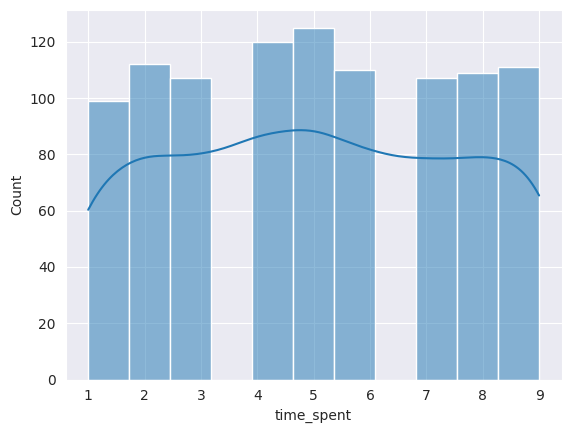

In [13]:
# histogram of time_spent
#plt.figure(figsize = (20,8))
sns.histplot(df_enc['time_spent'], kde=True)
plt.show()

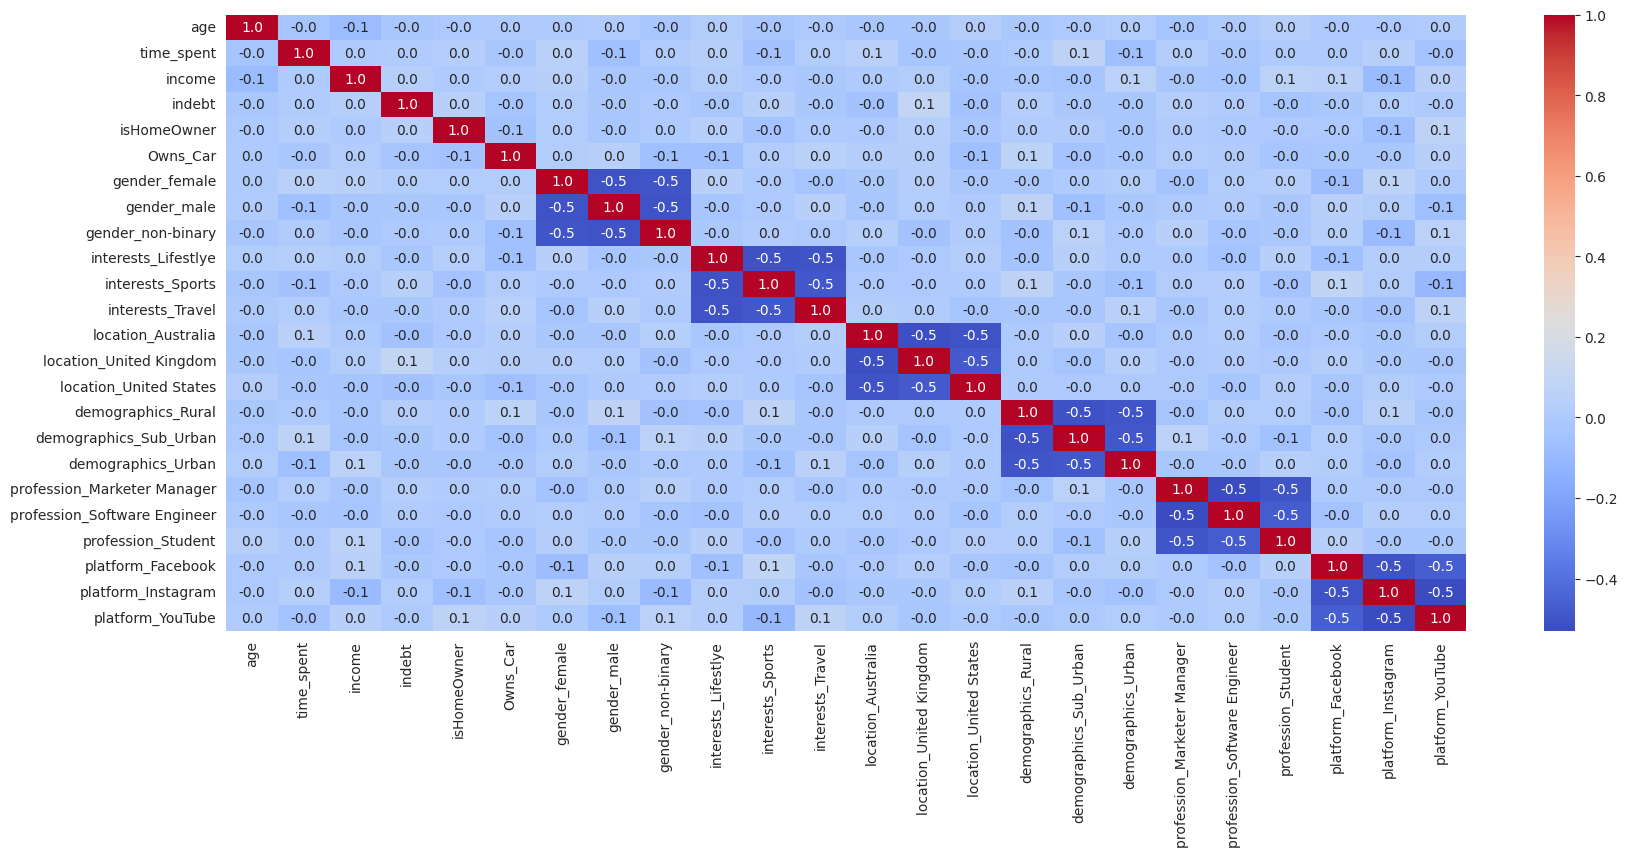

In [14]:
# correlation matrix
corr = df_enc.corr()
plt.figure(figsize = (20,8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.1f')
plt.show()


In [15]:
# normalize income and age
df_enc['income'] = (df_enc['income'] - df_enc['income'].min()) / (df_enc['income'].max() - df_enc['income'].min())
df_enc['age'] = (df_enc['age'] - df_enc['age'].min()) / (df_enc['age'].max() - df_enc['age'].min())    

In [16]:
df_enc

,age,time_spent,income,indebt,isHomeOwner,Owns_Car,gender_female,gender_male,gender_non-binary,interests_Lifestlye,...,location_United States,demographics_Rural,demographics_Sub_Urban,demographics_Urban,profession_Marketer Manager,profession_Software Engineer,profession_Student,platform_Facebook,platform_Instagram,platform_YouTube
0,0.826087,3,0.979334,True,False,False,False,True,False,False,...,False,False,False,True,False,True,False,False,True,False
1,0.608696,2,0.055377,True,True,True,True,False,False,False,...,False,False,False,True,False,False,True,True,False,False
2,0.304348,8,0.325642,False,False,False,False,True,False,False,...,False,False,True,False,True,False,False,False,True,False
3,0.913043,5,0.249599,False,True,False,False,False,True,False,...,False,False,False,True,False,False,True,False,True,False
4,0.152174,1,0.456862,False,True,True,False,True,False,True,...,False,False,False,True,False,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.086957,8,0.855136,False,True,False,True,False,False,True,...,False,True,False,False,True,False,False,False,True,False
996,0.478261,6,0.270766,True,False,False,False,False,True,False,...,False,True,False,False,False,True,False,False,False,True
997,0.195652,5,0.760734,True,False,True,False,False,True,False,...,False,True,False,False,False,False,True,False,False,True
998,0.934783,4,0.628110,True,True,False,True,False,False,False,...,False,False,True,False,True,False,False,False,False,True


In [52]:
# split the data into train, val and test
X = df_enc.drop('time_spent', axis=1)
y = df_enc['time_spent']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [18]:
X_train.shape, X_val.shape, X_test.shape

((640, 23), (160, 23), (200, 23))

In [19]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5],
        'eta': [0.01, 0.1, 0.2],
        }

In [20]:
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, nthread=1)

In [22]:
skf = StratifiedKFold(n_splits=5, shuffle = True, random_state=1001)
combined_X = pd.concat([X_train, X_val])
combined_y = pd.concat([y_train, y_val])
random_search = RandomizedSearchCV(model, param_distributions=params, n_iter=10000, scoring='neg_root_mean_squared_error', n_jobs=4, 
                                   cv=skf.split(combined_X, combined_y), verbose=3, random_state=1001)

random_search.fit(combined_X, combined_y)

Fitting 5 folds for each of 1215 candidates, totalling 6075 fits


/home/christian/Desktop/social-media-time-pred/venv/lib/python3.10/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 1215 is smaller than n_iter=10000. Running 1215 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV 1/5] END colsample_bytree=0.6, eta=0.01, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.6;, score=-2.613 total time=   0.2s
[CV 2/5] END colsample_bytree=0.6, eta=0.01, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.8;, score=-2.692 total time=   0.1s
[CV 5/5] END colsample_bytree=0.6, eta=0.01, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.8;, score=-2.588 total time=   0.1s
[CV 5/5] END colsample_bytree=0.6, eta=0.01, gamma=0.5, max_depth=3, min_child_weight=1, subsample=1.0;, score=-2.581 total time=   0.1s
[CV 3/5] END colsample_bytree=0.6, eta=0.01, gamma=0.5, max_depth=3, min_child_weight=5, subsample=0.6;, score=-2.541 total time=   0.1s
[CV 2/5] END colsample_bytree=0.6, eta=0.01, gamma=0.5, max_depth=3, min_child_weight=5, subsample=0.8;, score=-2.705 total time=   0.1s
[CV 1/5] END colsample_bytree=0.6, eta=0.01, gamma=0.5, max_depth=3, min_child_weight=5, subsample=1.0;, score=-2.601 total time=   0.1s
[CV 5/5] END colsample_bytree=0.6, eta=0.

RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x78de8a1b4200>,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=...
                                          multi_strategy=None,
                                          n_estimators=1000, n_jobs=None,
                                          nthread=1, num_parallel_tree=None, ...),
                   n_iter=10000, n_jobs=4,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'eta': [0.01, 0.1, 0.2],
                                        'gamma': [0.5, 1, 1.5, 2, 5],
                                        'max_depth': [3, 4, 5],
                                        'min_child_weight': [1, 5, 10],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=1001, scoring='neg_root_mean_squared_error',
                   verbose=3)

In [23]:
random_search.best_score_

-2.5449839969141523

In [24]:
random_search.best_params_

{'subsample': 1.0,
 'min_child_weight': 1,
 'max_depth': 4,
 'gamma': 5,
 'eta': 0.01,
 'colsample_bytree': 0.6}

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

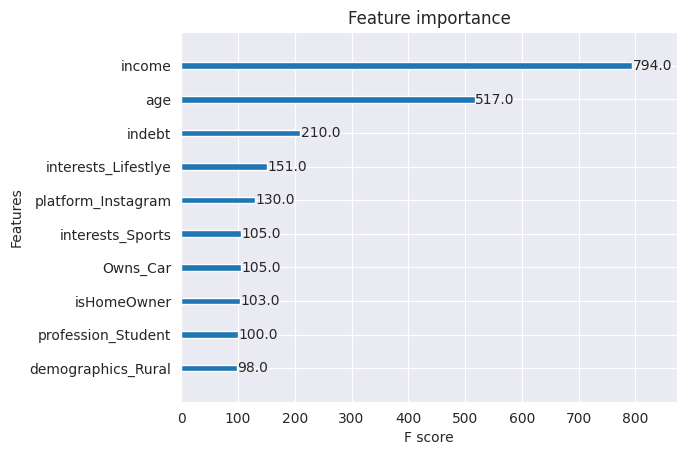

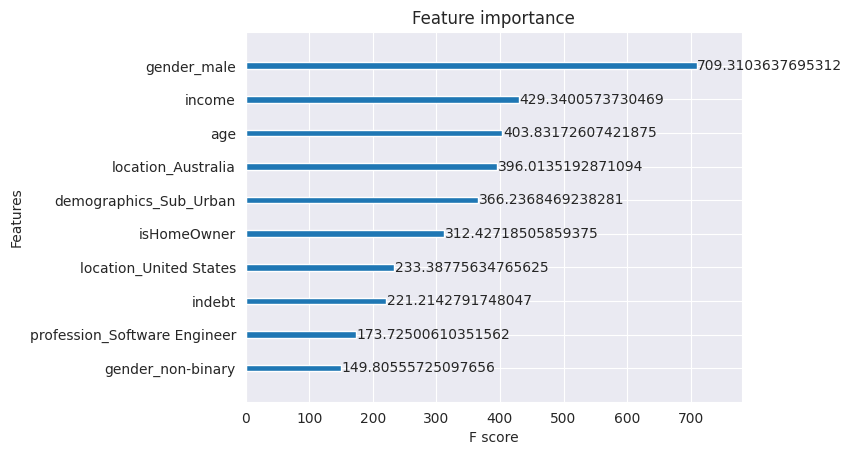

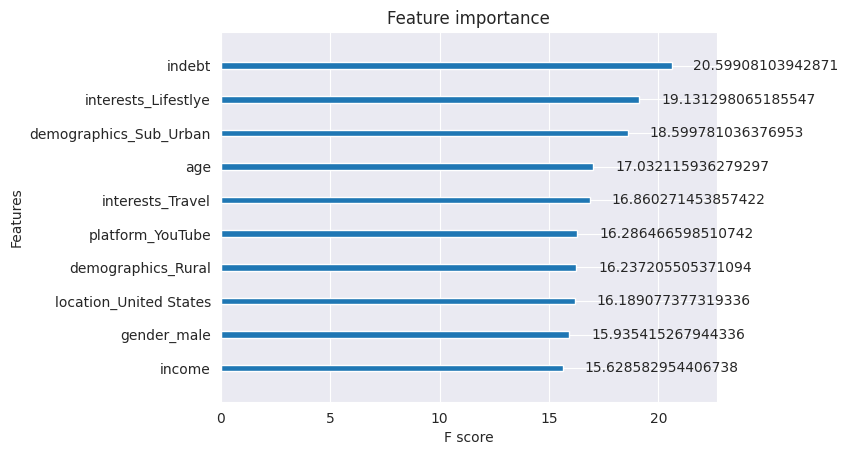

In [34]:
best_model = random_search.best_estimator_

#plot feature importance
xgb.plot_importance(best_model, max_num_features=10, importance_type='weight')
xgb.plot_importance(best_model, max_num_features=10, importance_type='cover')
xgb.plot_importance(best_model, max_num_features=10, importance_type='gain')

In [28]:
# only keep the 10 most important features

feature_importance = best_model.feature_importances_ # default importance type is 'gain'
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)
feature_importance_df


,feature,importance
2,indebt,0.058105
8,interests_Lifestlye,0.053965
15,demographics_Sub_Urban,0.052465
0,age,0.048043
10,interests_Travel,0.047559
22,platform_YouTube,0.045940
14,demographics_Rural,0.045801
13,location_United States,0.045665
6,gender_male,0.044950
1,income,0.044084


In [53]:
X_train_10 = X_train[feature_importance_df['feature'][:10]]
X_val_10 = X_val[feature_importance_df['feature'][:10]]
X_test_10 = X_test[feature_importance_df['feature'][:10]]
X_train_10.shape, X_val_10.shape, X_test_10.shape

((640, 10), (160, 10), (200, 10))

In [54]:
# train neural network with torch on reduced feature set

# convert to tensor
X_train_10 = torch.tensor(np.array(X_train_10.values, dtype=np.float32))
X_val_10 = torch.tensor(np.array(X_val_10.values, dtype=np.float32))
X_test_10 = torch.tensor(np.array(X_test_10.values, dtype=np.float32))

y_train = torch.tensor(np.array(y_train.values, dtype=np.float32))
y_val = torch.tensor(np.array(y_val.values, dtype=np.float32))
y_test = torch.tensor(np.array(y_test.values, dtype=np.float32))

In [71]:
class NeuralNet(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1, dropout=0.5):
        super(NeuralNet, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.dropout = torch.nn.Dropout(dropout)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(self.hidden_size, output_size)
        
    def forward(self, x):
        hidden = self.fc1(x)
        hidden = self.dropout(hidden)
        relu = self.relu(hidden)
        output = self.fc2(relu)
        return output

In [72]:
def train(model, criterion, optimizer, X_train, y_train, X_val, y_val, epochs=1000):
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        y_pred = model(X_train)
        loss = torch.sqrt_(criterion(y_pred, y_train)) # RMSE
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        
        model.eval()
        y_pred_val = model(X_val)
        loss_val = criterion(y_pred_val, y_val)
        val_losses.append(loss_val.item())
        
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Train Loss: {loss.item()}, Val Loss: {loss_val.item()}')
    return train_losses, val_losses

In [78]:
input_size = X_train_10.shape[1]
hidden_size = 32
nn_model = NeuralNet(input_size, hidden_size)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(nn_model.parameters(), lr=0.01, weight_decay=1)

/home/christian/Desktop/social-media-time-pred/venv/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([640])) that is different to the input size (torch.Size([640, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/christian/Desktop/social-media-time-pred/venv/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([160])) that is different to the input size (torch.Size([160, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, Train Loss: 5.489830493927002, Val Loss: 28.641191482543945
Epoch 100, Train Loss: 2.8434886932373047, Val Loss: 7.046928882598877
Epoch 200, Train Loss: 2.760378122329712, Val Loss: 6.647653579711914
Epoch 300, Train Loss: 2.6940646171569824, Val Loss: 6.538774013519287
Epoch 400, Train Loss: 2.697209358215332, Val Loss: 6.5348219871521
Epoch 500, Train Loss: 2.6995909214019775, Val Loss: 6.53451681137085
Epoch 600, Train Loss: 2.680392265319824, Val Loss: 6.525935173034668
Epoch 700, Train Loss: 2.704484701156616, Val Loss: 6.529008388519287
Epoch 800, Train Loss: 2.695366859436035, Val Loss: 6.524496078491211
Epoch 900, Train Loss: 2.692774534225464, Val Loss: 6.503731727600098
Epoch 1000, Train Loss: 2.686440944671631, Val Loss: 6.515800952911377
Epoch 1100, Train Loss: 2.682851552963257, Val Loss: 6.532742977142334
Epoch 1200, Train Loss: 2.680917501449585, Val Loss: 6.5187153816223145
Epoch 1300, Train Loss: 2.664858818054199, Val Loss: 6.516302585601807
Epoch 1400, Trai

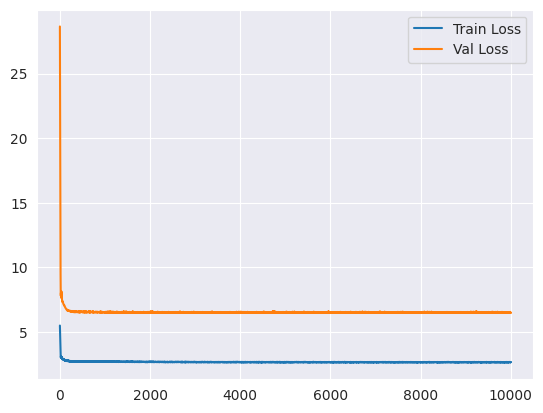

In [79]:
train_losses, val_losses = train(nn_model, criterion, optimizer, X_train_10, y_train, X_val_10, y_val, epochs=10000)

# plot the loss
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.show()

The neural network and the xgboost model have similar performance. Both models heavily overfit on the very small dataset.

In [80]:
# Augment data
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='auto', random_state=42)

X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
X_val_smote, y_val_smote = smote.fit_resample(X_val, y_val)

X_train_smote.shape, X_val_smote.shape

((720, 23), (180, 23))

In [81]:
X_train.shape


(640, 23)